In [66]:
import pandas as pd
from rich.jupyter import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
# import lightgbm as lgb
import matplotlib.pyplot as plt
from IPython.display import display
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
warnings.filterwarnings("ignore", category=UserWarning, module="LogisticRegression")


In [67]:
df = pd.read_csv('../../data/player_game_statistics.csv')
display(df.head())

,stat_id,player_id,player_name,age,gender,country,game_id,game_name,total_games_played,total_wins,total_losses,total_moves,total_time_played_minutes,win_ratio,rating,last_played
0,3407ea25-ba61-11ef-9d4e-00155d326b4e,d16771fa-ba60-11ef-9d4e-00155d326b4e,David Gonzales,34,Female,Canada,d0ac190e-ba60-11ef-9d4e-00155d326b4e,battleship,170,92,78,4914,5990,54.12,3,2024-12-08 14:35:00
1,3409a88e-ba61-11ef-9d4e-00155d326b4e,d133c41a-ba60-11ef-9d4e-00155d326b4e,Joseph Davis,18,Female,Japan,d0ac190e-ba60-11ef-9d4e-00155d326b4e,battleship,148,76,72,4220,5094,51.35,3,2024-12-05 08:24:00
2,3409bca3-ba61-11ef-9d4e-00155d326b4e,d15034ff-ba60-11ef-9d4e-00155d326b4e,Isabella Martin,51,Non-Binary,Spain,d0ac190e-ba60-11ef-9d4e-00155d326b4e,battleship,210,105,105,6053,7171,50.00,3,2024-12-10 11:00:00
3,340a17ca-ba61-11ef-9d4e-00155d326b4e,d15ee3cd-ba60-11ef-9d4e-00155d326b4e,Michael Thomas,33,Non-Binary,UK,d0ac190e-ba60-11ef-9d4e-00155d326b4e,battleship,119,61,58,3471,4285,51.26,3,2024-12-10 00:23:00
4,340a5066-ba61-11ef-9d4e-00155d326b4e,d1224a65-ba60-11ef-9d4e-00155d326b4e,Evelyn Thomas,18,Non-Binary,Brazil,d0ac190e-ba60-11ef-9d4e-00155d326b4e,battleship,147,79,68,4230,4969,53.74,3,2024-12-09 09:26:00


### Load and prepare data

In [68]:
# Prepare data for churn prediction by engineering relevant features

# Calculate days since last play
df['last_played'] = pd.to_datetime('now') - pd.to_datetime(df['last_played'])
df['days_since_last_play'] = df['last_played'].dt.days

# Engineer features
df['avg_session_duration'] = df['total_time_played_minutes'] / df['total_games_played']
df['win_rate'] = df['total_wins'] / df['total_games_played']
df['avg_moves_per_game'] = df['total_moves'] / df['total_games_played']

# # Define churn (players who haven't played in 30 days)
# df['churned'] = (df['days_since_last_play'] > 30).astype(int)

# Progressive disengagement
df['engagement_score'] = (df['total_time_played_minutes'] * 0.4 + 
                         df['total_games_played'] * 0.3 +
                         df['win_rate'] * 0.3)
df['churned'] = (df['engagement_score'] < df['engagement_score'].quantile(0.2)).astype(int)

# Select features for model
features = ['avg_session_duration', 'win_rate', 'avg_moves_per_game', 'total_games_played', 'age']

X = df[features]
y = df['churned']

In [69]:
display(X.head())
display(y.head())

,avg_session_duration,win_rate,avg_moves_per_game,total_games_played,age
0,35.235294,0.541176,28.905882,170,34
1,34.418919,0.513514,28.513514,148,18
2,34.147619,0.500000,28.823810,210,51
3,36.008403,0.512605,29.168067,119,33
4,33.802721,0.537415,28.775510,147,18


0    0
1    0
2    0
3    0
4    0
Name: churned, dtype: int32

In [70]:
display(df['engagement_score'])

0      2447.162353
1      2082.154054
2      2931.550000
3      1749.853782
4      2031.861224
          ...     
995     289.482609
996     315.604545
997     330.338462
998     105.712500
999     495.576471
Name: engagement_score, Length: 1000, dtype: float64

In [71]:
# Find the 20th percentile of engagement scores
threshold = df['engagement_score'].quantile(0.2)
print(f"20th percentile threshold: {threshold}")


20th percentile threshold: 180.3772307692308


In [72]:
# Check the new distribution
print("\nNew Churn Distribution:")
print(df['churned'].value_counts(normalize=True))

print("Mark players as churned (1) if below threshold")


New Churn Distribution:
churned
0    0.8
1    0.2
Name: proportion, dtype: float64
Mark players as churned (1) if below threshold


### Train churn prediction model

In [73]:
# Train logistic regression model for churn prediction

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # Train model
# model = LogisticRegression(class_weight='balanced')
# model.fit(X_train_scaled, y_train)
# 
# # Evaluate model
# y_pred = model.predict(X_test_scaled)
# print("Churn Prediction Model Performance:")
# print(classification_report(y_test, y_pred))

#### Train models

In [74]:
# Logistic Regression
log_reg = LogisticRegression(class_weight='balanced', random_state=42)
log_reg.fit(X_train_scaled, y_train)
log_reg_pred = log_reg.predict(X_test)

print("Logistic Regression Performance:")
print(f'Accuracy: {accuracy_score(y_test, log_reg_pred)}')
print(classification_report(y_test, log_reg_pred, zero_division=0))


Logistic Regression Performance:
Accuracy: 0.785
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       157
           1       0.00      0.00      0.00        43

    accuracy                           0.79       200
   macro avg       0.39      0.50      0.44       200
weighted avg       0.62      0.79      0.69       200



C:\Users\opeye\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [75]:
# Random Forest Classifier
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test)

print("Random Forest Performance:")
print(f'Accuracy: {accuracy_score(y_test, rf_pred)}')
print(classification_report(y_test, rf_pred, zero_division=0))

Random Forest Performance:
Accuracy: 0.785
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       157
           1       0.00      0.00      0.00        43

    accuracy                           0.79       200
   macro avg       0.39      0.50      0.44       200
weighted avg       0.62      0.79      0.69       200



C:\Users\opeye\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [76]:
# Gradient Boosting Machine (XGBoost)
xgb_model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False,random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test)

print("XGBoost Performance:")
print(f'Accuracy: {accuracy_score(y_test, xgb_pred)}')
print(classification_report(y_test, xgb_pred, zero_division=0))


XGBoost Performance:
Accuracy: 0.785
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       157
           1       0.00      0.00      0.00        43

    accuracy                           0.79       200
   macro avg       0.39      0.50      0.44       200
weighted avg       0.62      0.79      0.69       200



In [77]:
# Support Vector Machine (SVM)
svm_model = SVC(probability=True,random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test)

print("SVM Performance:")
print(f'Accuracy: {accuracy_score(y_test, svm_pred)}')
print(classification_report(y_test, svm_pred, zero_division=0))

SVM Performance:
Accuracy: 0.215
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       157
           1       0.21      1.00      0.35        43

    accuracy                           0.21       200
   macro avg       0.11      0.50      0.18       200
weighted avg       0.05      0.21      0.08       200



C:\Users\opeye\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


#### Ensemble Voting Classifier

In [78]:
# Ensemble Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('svm', svm_model)
    ],
    voting='soft'
)
voting_clf.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('log_reg',
                              LogisticRegression(class_weight='balanced',
                                                 random_state=42)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('svm', SVC(probability=True, random_state=42))],
                 voting='soft')

#### Model Evaluation

In [79]:
models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf_model,
    'Gradient Boosting': xgb_model,
    'SVM': svm_model,
    'Voting Classifier': voting_clf
}

for name, model in models.items():
    if name == 'Random Forest' or name == 'Gradient Boosting':
        preds = model.predict(X_test)
        probs = model.predict_proba(X_test)[:, 1]
    else:
        preds = model.predict(X_test_scaled)
        probs = model.predict_proba(X_test_scaled)[:, 1]

    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy_score(y_test, preds):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, probs):.4f}")
    print(classification_report(y_test, preds, zero_division=0))

--- Logistic Regression ---
Accuracy: 0.8900
ROC-AUC: 0.9938
              precision    recall  f1-score   support

           0       1.00      0.86      0.92       157
           1       0.66      1.00      0.80        43

    accuracy                           0.89       200
   macro avg       0.83      0.93      0.86       200
weighted avg       0.93      0.89      0.90       200

--- Random Forest ---
Accuracy: 0.7850
ROC-AUC: 0.4185
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       157
           1       0.00      0.00      0.00        43

    accuracy                           0.79       200
   macro avg       0.39      0.50      0.44       200
weighted avg       0.62      0.79      0.69       200

--- Gradient Boosting ---
Accuracy: 0.7850
ROC-AUC: 0.5000
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       157
           1       0.00      0.00      0.00        43

    acc

C:\Users\opeye\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\opeye\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


#### Predictions

In [80]:
# Predictions
log_reg_pred = log_reg.predict(X_test_scaled)
xgb_pred = xgb_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
svm_pred = svm_model.predict(X_test_scaled)
voting_pred = voting_clf.predict(X_test_scaled)

C:\Users\opeye\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [81]:
# Collecting all models' results
models = ['Logistic Regression', 'XGBoost', 'SVM', 'Random Forest', 'Voting Classifier']
accuracies = [
    accuracy_score(y_test, log_reg_pred),
    accuracy_score(y_test, xgb_pred),
    accuracy_score(y_test, svm_pred),
    accuracy_score(y_test, rf_pred),
    accuracy_score(y_test, voting_pred)
]

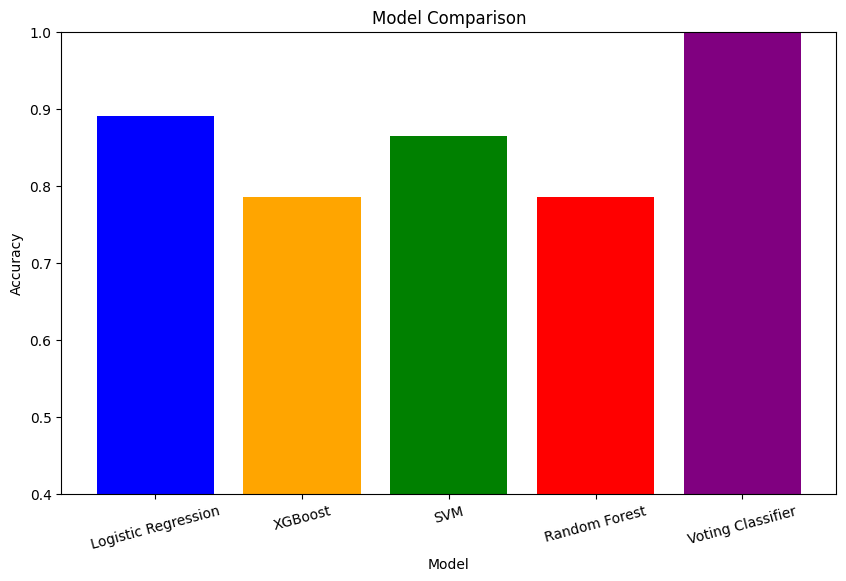

In [82]:
# Plotting the comparison
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0.4, 1.0)  # Adjust as necessary
plt.xticks(rotation=15)
plt.show()

#### Save model and scaler

In [ ]:
# Save model and scaler
import pickle
with open('churn_model.pkl', 'wb') as f:
    pickle.dump(log_reg, f)
with open('churn_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)